# Import Libraries and Files

In [1]:
from DiscreteDeepRobots import ThreeLinkRobot
from math import pi, log
from mpl_toolkits.mplot3d import Axes3D
import random
import numpy as np
import pandas as pd
import copy
%matplotlib notebook
# %matplotlib inline
import matplotlib.pyplot as plt

# Q-Learning and Auxiliary Functinos

In [8]:
def Qlearner(num_robots, alpha, gamma, epsilon, theta_lower, theta_upper, a1_lower, a1_upper, 
             a2_lower, a2_upper, a_lower, a_upper, angle_interval, graphs = False, live_graphs = False, Qvalues=None):
    """
    :param num_robots: number of robots
    :param alpha: learning rate
    :param gamma: discount rate
    :param epsilon: probability of choosing random action while learning
    :param theta_lower: lower limit of theta in state space
    :param theta_upper: upper limit of theta in state space
    :param a1_lower: lower limit of a1 in state space
    :param a1_upper: upper limit of a1 in state space
    :param a2_lower: lower limit of a2 in state space
    :param a2_upper: upper limit of a2 in state space
    :param a_lower: lower limit of action space
    :param a_upper: upper limit of action space
    :param angle_interval: interval of state and action space
    :param graphs: whether to generate graphs
    :param live_graphs: whether to generate dynamics graphs
    :return: a tuple of learned q-values, states, actions
    """

    # initialize state space, action space, and Qvalues
    print('loading state space')
    states = get_state_space(theta_lower, theta_upper,a1_lower,
                             a1_upper, a2_lower, a2_upper, angle_interval)  # state = (theta, a1, a2)
    print(len(states), 'states loaded')
    print('loading action space')
    actions = get_action_space(a_lower, a_upper, angle_interval)  # action = (a1dot, a2dot)
    print(len(actions), 'actions loaded')
    if Qvalues is None:
        Qvalues = {}
        print('initializing Qvalues')
        for state in states:
            for action in actions:
                Qvalues[(state, action)] = 0
        print(len(Qvalues.keys()), 'q-values loaded')
    else:
        print('Pretrained Qvalues loaded')

    # learn q-values
    print('\n\n')
    details = {}
    
    for j in range(num_robots):
        print(j+1, ' ith ', 'robot is learning')
        state = random.choice(states)
        robot = ThreeLinkRobot(x=0, 
                               y=0, 
                               theta=state[0], 
                               a1=state[1],
                               a2=state[2],
                               link_length=2, 
                               t_interval=0.01, 
                               a_interval=angle_interval)
        i = 0
        
        # plotting
        xs = [robot.x]
        a1s = [robot.a1]
        a2s = [robot.a2]
        timesteps = [i]
        
        while True:
            i += 1
            # print('For', j, 'th robot', 'In', i, 'th iteration the initial state is: ', state)
            # employ an epsilon-greedy strategy for exploration vs exploitation
            best_actions = []
            if random.random() < epsilon:

                # choose a random action
                best_actions = actions
            else:

                # find the best actions (the ones with largest q-value)
                maxQ = -float("inf")
                for action in actions:
                    Q = Qvalues[(state, action)]
                    if Q > maxQ:
                        best_actions = [action]
                        maxQ = Q
                    elif Q == maxQ:
                        best_actions.append(action)

            # randomly select a tie-breaking, valid action
            while True:
                best_action = random.choice(best_actions)
                # print('The action randomly chosen is', best_action)
                temp_robot = copy.deepcopy(robot)
                temp_robot.move(best_action[0], best_action[1], 1)
                if (temp_robot.theta, temp_robot.a1, temp_robot.a2) in states:
                    break
            robot = temp_robot
            # print('In', i, 'th iteration the best action is: ', best_action)

            # transition to new state
            new_state = robot.state
            # print('In', i, 'th iteration the new state is: ', new_state)
            
            # add values to lists
            xs.append(robot.x)
            a1s.append(robot.a1)
            a2s.append(robot.a2)
            timesteps.append(i)

            # plotting
            if live_graphs:
                make_graphs(xs,a1s,a2s,timesteps,j+1,live=True, Q=True)
            

            # find the maximum Q value for new state
            Q = -float("inf")
            for action in actions:
                Q = max(Q, Qvalues[(new_state, action)])

            # find the reward of this transition
            reward = 0
            a1, a2, R, v, a1dot, a2dot = robot.a1, robot.a2, robot.R, robot.body_v[0], robot.a1dot, robot.a2dot
            
            '''
            # penalize according to joint proximity
            if a1 == a2:
                reward += -10*R
            
            else:
                print('In ', i, 'th iteration the penalty for joint angle proximity is: ', log(a1-a2), 'for joint angles: ', a1, a2)
                reward += log(a1-a2)
            '''
            
            # print('In ', i, 'th iteration the reward for x- velocity is: ', v/(a1dot**2 + a2dot**2), 'for velocity, a1dot, a2dot: ', v, a1dot, a2dot)
            reward += v/(a1dot**2 + a2dot**2)

            # TD update
            sample = gamma * Q
            old_Q = Qvalues[(state, best_action)]
            # print('In ', i, 'th iteration the Q value before update is: ', old_Q)
            new_Q = (1 - alpha) * old_Q + alpha * (reward + sample)
            Qvalues[(state, best_action)] = new_Q
            # print('In ', i, 'th iteration the Q value after update is: ', new_Q)
            state = new_state

            # check for convergence
            if old_Q == 0:
                pass
            elif abs((new_Q-old_Q)/old_Q) <= 0.05:
                print('algorithm converged')
                break
        if graphs:
            make_graphs(xs, a1s, a2s, timesteps, j,Q=True)
        details[j] = (xs, a1s, a2s, timesteps)
        
    return Qvalues, states, actions, details

In [9]:
def get_action_space(lower_limit, upper_limit, interval):
    """
    auxiliary function used by Qlearner() to get action space
    :return: a list of action space values in tuple format (a1dot, a2dot)
    """
    upper_limit += (interval/10)  # to ensure the range covers the rightmost value in the loop
    r = np.arange(lower_limit, upper_limit, interval)
    space = [(rnd(i), rnd(j)) for i in r for j in r]

    # remove a1dot = 0, a2dot = 0 from action space
    space.remove((0,0))

    return space


def get_state_space(theta_lower, theta_upper,
                    a1_lower, a1_upper, a2_lower, a2_upper, angle_interval):
    """
    auxiliary function used by Qlearner() to get action space
    :return: a list of state space values in tuple format (a1, a2, theta)
    """
    # to ensure the range covers the rightmost value in the loop
    theta_upper += (angle_interval/10)
    a1_upper += (angle_interval/10)
    a2_upper += (angle_interval/10)

    theta_range = np.arange(theta_lower, theta_upper, angle_interval)
    a1_range = np.arange(a1_lower, a1_upper, angle_interval)
    a2_range = np.arange(a2_lower, a2_upper, angle_interval)
    space = [(rnd(theta), rnd(a1), rnd(a2)) for theta in theta_range for a1 in a1_range for a2 in a2_range]

    return space

In [10]:
def rnd(number):
    return round(number, 8)

In [11]:
def make_graphs(xs, a1s, a2s, timesteps, robot_num, live=False, Q=False):
    # plotting
    fig1 = plt.figure(1)
    if Q:
        fig1.suptitle('Q-learning Monitor for robot ' + str(robot_num))
    else:
        fig1.suptitle('Policy Rollout')
    ax1 = fig1.add_subplot(311)
    ax2 = fig1.add_subplot(312)
    ax3 = fig1.add_subplot(313)
    fig2 = plt.figure(2)
    ax4 = fig2.add_subplot(111, projection='3d')
    
    ax1.plot(timesteps, xs, '.-')
    ax1.set_ylabel('x')
    ax2.plot(timesteps, a1s, '.-')
    ax2.set_ylabel('a1')
    ax3.plot(timesteps, a2s, '.-')
    ax3.set_ylabel('a2')
    
    ax4.set_title('3D Monitor for a1, a2 vs time')
    ax4.plot(timesteps, a1s, a2s, '.-')
    fig1.tight_layout()
    fig2.tight_layout()
    plt.tight_layout()
    plt.show()
 

# Policy and Q-value Testing Functions

In [12]:
def extract_policy(model, states, actions, Qvalues = None):
    policy = {}
    if model is not None:
        for state in states:
            maxQ = -float("inf")
            best_action = None
            for action in actions:
                feature = [val for val in state]
                for val in action: 
                    feature.append(val)
                Q = model.predict(np.array([np.array(feature)]))
                maxQ = max(Q, maxQ)
                if Q == maxQ:
                    best_action = action
            policy[state] = best_action
    else:
        for state in states:
            maxQ = -float("inf")
            best_action = None
            for action in actions:
                Q = Qvalues[(state, action)]
                maxQ = max(Q, maxQ)
                if Q == maxQ:
                    best_action = action
            policy[state] = best_action
    return policy


def test_policy(robot, policy, timestep=20):
    dx = 0
    dxs = []
    a1s = []
    a2s = []
    timesteps = []
    plt.title('Policy Rollout')
    for i in range(timestep):
        
        # rollout
        initial_state = robot.state
        print('In', i, 'th iteration the initial state is: ', initial_state)
        old_x = robot.x
        action = policy[initial_state]
        print('In', i, 'th iteration the chosen action is: ', action)
        robot.move(action[0], action[1], 1)
        new_x = robot.x
        print('In ', i, 'th iteration, the robot moved ', new_x - old_x, ' in x direction')
        dx += (new_x-old_x)
        
        # add values to lists
        dxs.append(dx)
        a1s.append(robot.a1)
        a2s.append(robot.a2)
        timesteps.append(i)
        
        # plotting
        make_graphs(dxs,a1s,a2s,timesteps,0,live=True)
        
        plt.plot(a1s,a2s,'.-')
        plt.xlabel('a1')
        plt.ylabel('a2')
        plt.show()
        
        
    plt.show()
    return dx

# Testing

In [13]:
# learn Q values
Qvalues, states, actions, details = Qlearner(num_robots=300,
        alpha=0.5,
        gamma=0.9,
        epsilon=0.5,
        theta_lower=-pi/8,
        theta_upper=pi/8,
        a1_lower=pi/32,
        a1_upper=pi/8,
        a2_lower=-pi/8,
        a2_upper=-pi/32,
        a_lower=-pi/8,
        a_upper=pi/8,
        angle_interval=pi/32,
        graphs=False,
        live_graphs=False)

loading state space
144 states loaded
loading action space
80 actions loaded
initializing Qvalues
11520 q-values loaded



1  ith  robot is learning
algorithm converged
2  ith  robot is learning
algorithm converged
3  ith  robot is learning
algorithm converged
4  ith  robot is learning
algorithm converged
5  ith  robot is learning
algorithm converged
6  ith  robot is learning
algorithm converged
7  ith  robot is learning
algorithm converged
8  ith  robot is learning
algorithm converged
9  ith  robot is learning
algorithm converged
10  ith  robot is learning
algorithm converged
11  ith  robot is learning
algorithm converged
12  ith  robot is learning
algorithm converged
13  ith  robot is learning
algorithm converged
14  ith  robot is learning
algorithm converged
15  ith  robot is learning
algorithm converged
16  ith  robot is learning
algorithm converged
17  ith  robot is learning
algorithm converged
18  ith  robot is learning
algorithm converged
19  ith  robot is learning
algorithm con

algorithm converged
210  ith  robot is learning
algorithm converged
211  ith  robot is learning
algorithm converged
212  ith  robot is learning
algorithm converged
213  ith  robot is learning
algorithm converged
214  ith  robot is learning
algorithm converged
215  ith  robot is learning
algorithm converged
216  ith  robot is learning
algorithm converged
217  ith  robot is learning
algorithm converged
218  ith  robot is learning
algorithm converged
219  ith  robot is learning
algorithm converged
220  ith  robot is learning
algorithm converged
221  ith  robot is learning
algorithm converged
222  ith  robot is learning
algorithm converged
223  ith  robot is learning
algorithm converged
224  ith  robot is learning
algorithm converged
225  ith  robot is learning
algorithm converged
226  ith  robot is learning
algorithm converged
227  ith  robot is learning
algorithm converged
228  ith  robot is learning
algorithm converged
229  ith  robot is learning
algorithm converged
230  ith  robot is l

## Graph Analysis of Testing Data

In [ ]:
# graphing Q learning details
for k in details.keys():
    xs, a1s, a2s, timesteps = details[k]
    %matplotlib inline
    make_graphs(xs, a1s, a2s, timesteps, k+1, Q=True)

In [ ]:
# graph Fourier transform
for k in details.keys():
    xs, a1s, a2s, timesteps = details[k]
    xs_ = np.fft.fft(xs)
    fig = plt.figure(1)
    ax1 = fig.add_subplot(311)
    ax1.plot(timesteps, xs_,'.-')

    a1s_ = np.fft.fft(a1s)
    ax2 = fig.add_subplot(312)
    ax2.plot(timesteps, a1s_,'.-')

    a2s_ = np.fft.fft(a2s)
    ax3 = fig.add_subplot(313)
    ax3.plot(timesteps, a2s_,'.-')
    # %matplotlib inline
    plt.show()


## Prepare Training Input(X) and Output(Y)

In [14]:
X, Y = [], []
for key in Qvalues:
    if Qvalues[key] == 0:
        continue
    else:
        feature = []
        for element in key:
            for val in element:
                feature.append(val)
        X.append(np.array(feature))
        Y.append(Qvalues[key])
X, Y = np.array(X),np.array(Y)
print(len(X), len(Y))

892 892


In [ ]:
X[0:1]

In [ ]:
Y[:1]

## Functional Approximation with Neural Networks

### Import Libraries

In [15]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


### visualize number of null Q values vs number of valid Q values learned

In [16]:
# visualize number of null Q values vs number of valid Q values learned
num_of_null_Q, num_of_valid_Q = 0,0
for key in Qvalues:
    if Qvalues[key] == 0:
        num_of_null_Q += 1
    else:
        num_of_valid_Q += 1
print(num_of_null_Q, num_of_valid_Q)

10628 892


### Define NN result plotting function and early stopping

In [17]:
# plot history function
def plot_history(history):
    # acc = history.history['acc']
    # val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 5))
    #plt.subplot(1, 2, 1)
    # plt.plot(x, acc, 'b', label='Training acc')
    # plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation loss')
    # plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.legend()
    plt.show()
    plt.close()

In [18]:
# early stopping is used to prevent overtraining -> we will stop the training "early" if it has reached maximum accuracy
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto',restore_best_weights=True)
callbacks_list = [early_stopping]

### Training Neural Network

In [46]:
# specify the input and output dimensions of the neural network
input_dim = 5
output_dim = 1

model = Sequential()
# input layer
model.add(Dense(5, input_dim=input_dim, activation = 'relu'))
# hidden layers
model.add(Dense(100, activation = 'relu'))
model.add(Dense(500, activation = 'relu'))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
# output layer
model.add(Dense(output_dim, activation = 'linear'))
# Compile the architecture and view summary
model.compile(loss='mse',optimizer='adam')
history = model.fit(X, Y,
                    epochs=20,
                    verbose=1,
                    validation_data = (X, Y),
                    callbacks=callbacks_list,
                    batch_size=8)
print(model.summary())

Train on 892 samples, validate on 892 samples
Epoch 1/20
892/892 [==============================] - 2s 3ms/step - loss: 910.2145 - val_loss: 742.8578
Epoch 2/20
892/892 [==============================] - 1s 738us/step - loss: 708.3948 - val_loss: 682.3561
Epoch 3/20
892/892 [==============================] - 1s 677us/step - loss: 687.6057 - val_loss: 669.7563
Epoch 4/20
892/892 [==============================] - 1s 716us/step - loss: 675.2605 - val_loss: 654.2814
Epoch 5/20
892/892 [==============================] - 1s 744us/step - loss: 665.2988 - val_loss: 643.1684
Epoch 6/20
892/892 [==============================] - 1s 657us/step - loss: 657.7471 - val_loss: 636.9288
Epoch 7/20
892/892 [==============================] - 1s 643us/step - loss: 648.9801 - val_loss: 632.3366
Epoch 8/20
892/892 [==============================] - 1s 680us/step - loss: 638.3368 - val_loss: 629.5990
Epoch 9/20
892/892 [==============================] - 1s 643us/step - loss: 633.2104 - val_loss: 630.7204
Ep

In [47]:
# print the loss of the model on training and validation set  
loss = model.evaluate(X, Y, verbose=False)
print("Training Loss: {:.4f}".format(loss))

Training Loss: 603.4665


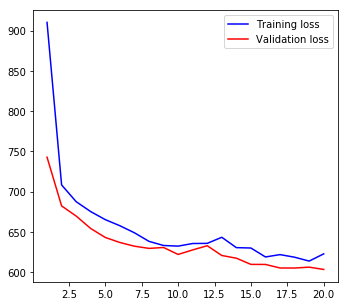

In [48]:
# plot history
%matplotlib inline
plot_history(history)

### Sanity Check

In [45]:
data = {'y_real':Y[0:50],'y_pred':(model.predict(X[0:50])).reshape(1,-1)[0]}
pd.DataFrame(data)

,y_pred,y_real
0,19.546085,16.536465
1,18.235676,-4.229162
2,26.011293,29.969784
3,35.917809,29.207010
4,25.957968,39.335049
5,31.383034,34.378785
6,29.683189,69.642034
7,24.480740,7.834888
8,21.764273,11.867832
9,21.059557,6.534740


## Functional Approximation with Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Using default, off-the-shelf random forest algorithm
# Instantiate model with 100 decision trees
rf = RandomForestRegressor(n_estimators = 100)
# Train the model on training data
rf.fit(X, Y)

### Sanity Check

In [ ]:
data = {'y_real':Y[0:50],'y_pred':(rf.predict(X[0:50])).reshape(1,-1)[0]}
pd.DataFrame(data)

### Calculate MAE

In [ ]:
# MAE
# Use the forest's predict method on the test data
predictions = rf.predict(X)

# Calculate the absolute errors
errors = abs(predictions - Y)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

## Politcy Rollout with NN

In [ ]:
# extract policy
policy_NN = extract_policy(model, states, actions)

In [ ]:
robot2 = ThreeLinkRobot(x=0,
                       y=0,
                       theta=0,
                       a1=pi/16,
                       a2=-pi/16,
                       link_length=2,
                       t_interval=0.01,
                       a_interval=pi/32)
%matplotlib inline
x_displacement = test_policy(robot=robot2, policy=policy_NN, timestep=100)

## Politcy Rollout with Random Forest

In [ ]:
# extract policy
policy_RF = extract_policy(rf, states, actions)

In [ ]:
robot3 = ThreeLinkRobot(x=0,
                       y=0,
                       theta=0,
                       a1=pi/16,
                       a2=-pi/16,
                       link_length=2,
                       t_interval=0.01,
                       a_interval=pi/32)
%matplotlib inline
x_displacement = test_policy(robot=robot3, policy=policy_RF, timestep=100)

## Continue Learning after Random Forest Functional Approximation

In [ ]:
# fill in null Q values with Random Forest Predictions
for key in Qvalues:
    if Qvalues[key] != 0:
        continue
    else:
        state_action = []
        for element in key:
            for val in element:
                state_action.append(val)
        Q = rf.predict(np.array([np.array(state_action)]))
        Qvalues[key] = Q

In [ ]:
# visualize number of null Q values vs number of valid Q values learned
num_of_null_Q, num_of_valid_Q = 0,0
for key in Qvalues:
    if Qvalues[key] == 0:
        num_of_null_Q += 1
    else:
        num_of_valid_Q += 1
print(num_of_null_Q, num_of_valid_Q)

In [ ]:
# learn Q values
Qvalues, states, actions, details = Qlearner(num_robots=1000,
        alpha=0.5,
        gamma=0.9,
        epsilon=0.5,
        theta_lower=-pi/8,
        theta_upper=pi/8,
        a1_lower=pi/32,
        a1_upper=pi/8,
        a2_lower=-pi/8,
        a2_upper=-pi/32,
        a_lower=-pi/8,
        a_upper=pi/8,
        angle_interval=pi/32,
        graphs=False,
        live_graphs=False,
        Qvalues = Qvalues)

## Test Again and Final Policy Rollout

In [ ]:
# graphing Q learning details
for k in details.keys():
    xs, a1s, a2s, timesteps = details[k]
    %matplotlib inline
    make_graphs(xs, a1s, a2s, timesteps, k+1, Q=True)

In [ ]:
# graph Fourier transform
for k in details.keys():
    xs, a1s, a2s, timesteps = details[k]
    xs_ = np.fft.fft(xs)
    fig = plt.figure(1)
    ax1 = fig.add_subplot(311)
    ax1.plot(timesteps, xs_,'.-')

    a1s_ = np.fft.fft(a1s)
    ax2 = fig.add_subplot(312)
    ax2.plot(timesteps, a1s_,'.-')

    a2s_ = np.fft.fft(a2s)
    ax3 = fig.add_subplot(313)
    ax3.plot(timesteps, a2s_,'.-')
    # %matplotlib inline
    plt.show()

In [ ]:
# extract policy
policy = extract_policy(model = None, states = states, actions = actions, Qvalues = Qvalues)

In [ ]:
policy

In [ ]:
len(states), len(actions)

In [ ]:
robot4 = ThreeLinkRobot(x=0,
                       y=0,
                       theta=pi/32,
                       a1=pi/16,
                       a2=-pi/16,
                       link_length=2,
                       t_interval=0.001,
                       a_interval=pi/32)
%matplotlib inline
x_displacement = test_policy(robot=robot4, policy=policy, timestep=100)